In [2]:
%matplotlib inline

from functools import partial
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

import matplotlib.pyplot as plt

In [3]:
%run data.py

In [4]:
#_download_dataset()

In [5]:
df = get_data_dataframe()
df.head()

,type,person,label,height,width,channel,filename
0,train,21,forg,452,808,3,sign_data/train/021_forg/04_0211021.PNG
1,train,21,forg,334,588,3,sign_data/train/021_forg/04_0204021.PNG
2,train,21,forg,302,490,3,sign_data/train/021_forg/04_0110021.PNG
3,train,21,forg,298,479,3,sign_data/train/021_forg/01_0110021.PNG
4,train,21,forg,456,657,3,sign_data/train/021_forg/02_0211021.PNG


In [6]:
df[['height', 'width']].describe()

,height,width
count,2149.000000,2149.000000
mean,275.376919,656.729176
std,95.509558,180.437213
min,83.000000,229.000000
25%,205.000000,526.000000
50%,266.000000,651.000000
75%,345.000000,783.000000
max,778.000000,1372.000000


In [7]:
df_train = df[(df['label'] == 'real') & (df['type'] == 'train')]
df_test = df[(df['label'] == 'real') & (df['type'] == 'test')]

In [8]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest',
)

In [9]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
image_sizes = (256, 256)

In [11]:
train_generator = train_datagen.flow_from_dataframe(df_train,
target_size=image_sizes,
batch_size=64,
class_mode='input',
color_mode ='grayscale')

Found 887 validated image filenames.


In [12]:
test_generator = test_datagen.flow_from_dataframe(df_test, target_size=image_sizes, batch_size=16, class_mode='input', color_mode ='grayscale')

Found 252 validated image filenames.


In [13]:
conv_layer = partial(keras.layers.Conv2D, kernel_size=(3,3), activation='selu', padding='same')
conv_t_layer = partial(keras.layers.Conv2DTranspose, kernel_size=(3,3), strides=2, activation='selu', padding='same')

In [14]:
encoder = keras.Sequential([
    conv_layer(filters=32, strides=2, input_shape=(*image_sizes, 1)),
    conv_layer(32),
    keras.layers.MaxPooling2D(),
    conv_layer(64),
    keras.layers.MaxPooling2D(),
    conv_layer(64),
    keras.layers.MaxPooling2D(),
    conv_layer(128),
    keras.layers.MaxPooling2D(),
    conv_layer(128),
    keras.layers.MaxPooling2D()
])

2021-07-10 15:04:42.771235: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0

In [16]:
decoder = keras.Sequential([
    conv_t_layer(128, input_shape=encoder.output_shape[1:]),
    conv_t_layer(128),
    conv_t_layer(64),
    conv_t_layer(64),
    conv_t_layer(32),
    conv_t_layer(1, kernel_size=(5,5), activation='sigmoid')
])

In [17]:
conv_ae = keras.models.Sequential([encoder, decoder])

In [18]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001)
conv_ae.compile(loss="binary_crossentropy", optimizer=optimizer)

In [19]:
conv_ae.fit(train_generator, validation_data=test_generator)

2021-07-10 15:04:43.436282: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-07-10 15:04:43.455673: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz
14/14 [==============================] - 27s 2s/step - loss: 0.4969 - val_loss: 0.2052


In [55]:
class PlotReconstruction(keras.callbacks.Callback):
    def __init__(self, num_images=5, **kwargs):
        self.num_images = num_images
        super(PlotReconstruction, self).__init__(**kwargs)
    def on_epoch_end(self, epoch, logs):
        x_batch, y_batch = train_generator.next()
        x_batch = x_batch[:self.num_images]
        reconstruct_batch = self.model.predict(x_batch)
        x_batch *= 255.
        reconstruct_batch *= 255.

        fig = plt.figure(figsize=(2*self.num_images, 3))
        for i in range(self.num_images):
            plt.subplot(2, self.num_images, i+1)
            plt.imshow(x_batch[i], cmap='binary')
            plt.subplot(2, self.num_images, i+num_images+1)
            plt.imshow(reconstruct_batch[i], cmap='binary')
        plt.show();

In [56]:
reconstruction_cb = PlotReconstruction()

Epoch 1/5
14/14 [==============================] - 29s 2s/step - loss: 0.2118 - val_loss: 0.1983


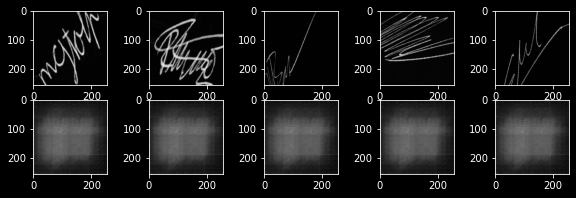

Epoch 2/5
14/14 [==============================] - 30s 2s/step - loss: 0.2098 - val_loss: 0.2018


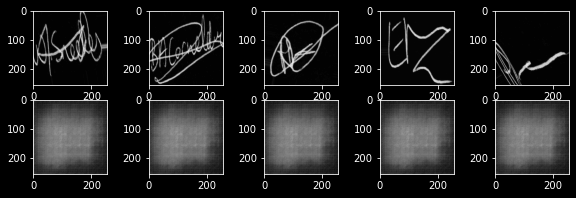

Epoch 3/5
14/14 [==============================] - 30s 2s/step - loss: 0.2101 - val_loss: 0.1995


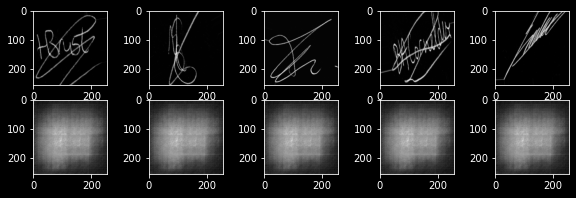

Epoch 4/5
14/14 [==============================] - 30s 2s/step - loss: 0.2109 - val_loss: 0.1986


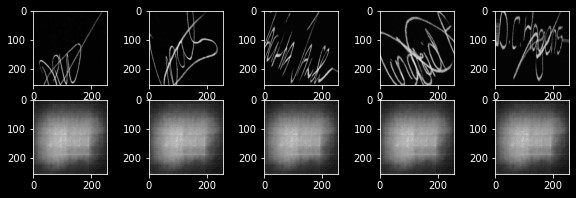

Epoch 5/5
14/14 [==============================] - 30s 2s/step - loss: 0.2103 - val_loss: 0.1980


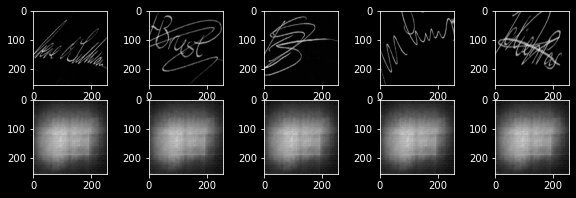

In [57]:
conv_ae.fit(train_generator, validation_data=test_generator, callbacks=[reconstruction_cb], epochs=5)

In [37]:
num_images = 5

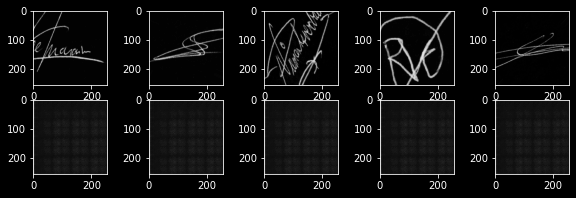

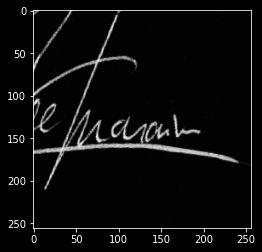

In [36]:

plt.imshow(x_batch[0], cmap='binary', )